In [ ]:
!pip3 install alpha_vantage

In [287]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn
from sklearn import metrics
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from math import sqrt

## QUESTION 1

In [22]:
ts = TimeSeries(key='WE261JF3DCYAH41W', output_format='pandas')

google_data, google_meta = ts.get_daily('GOOGL', outputsize='full')
apple_data, apple_meta = ts.get_daily('AAPL', outputsize='full')
fb_data, fb_meta = ts.get_daily('FB', outputsize='full')

## QUESTION 2

* **.pct_change()** function in pandas library counts percentage change between the elements (rows) of the dataset.


### Apple

In [42]:
apple_returns = apple_data['4. close'].pct_change()

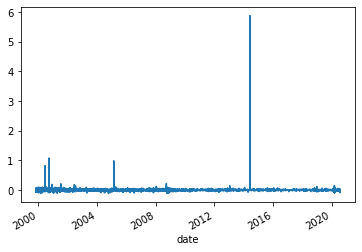

In [63]:
apple_returns.plot()

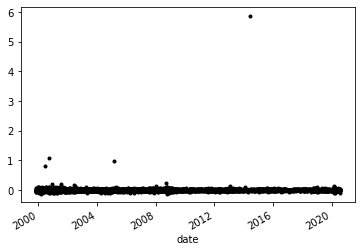

In [53]:
apple_returns.plot(style='k.')

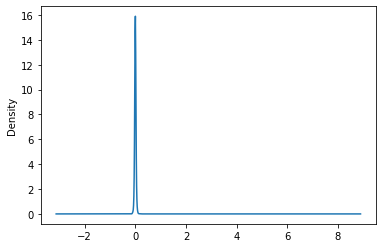

In [64]:
##probability density function

apple_returns.plot(kind='kde')

### FB

In [54]:
fb_returns = fb_data['4. close'].pct_change()

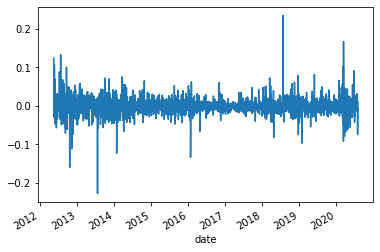

In [62]:
fb_returns.plot()

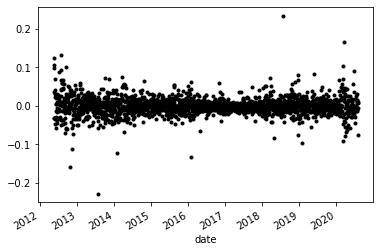

In [55]:
fb_returns.plot(style='k.')

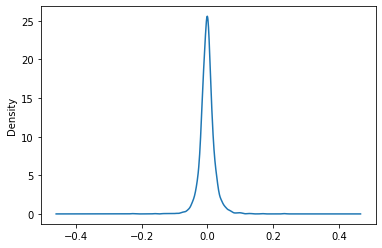

In [61]:
#probability density function

fb_returns.plot(kind='kde')

In [69]:
fb_returns.std()

0.023303306319298858

In [70]:
fb_returns.mean()

-0.0006368849103209989

### Google

In [164]:
google_returns = google_data['4. close'].pct_change()

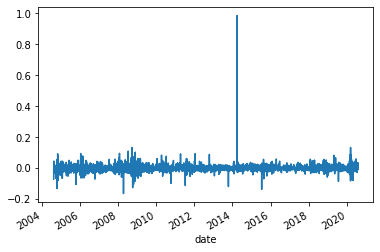

In [59]:
google_returns.plot()

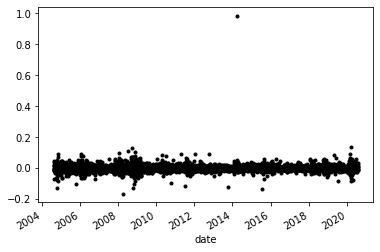

In [60]:
google_returns.plot(style='k.')

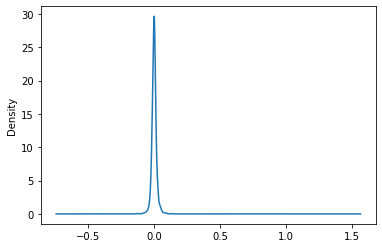

In [65]:
#probability density function
google_returns.plot(kind='kde')

* **What is its distribution?**

Looking at all the plots with density functions above we can figure that they look more like t-distribution because of more heavier tails thain in normal distribution

* **Is the distribution stationary over time?**

Stationary distribution doesn't have any trends or seasonal effects. Let's make some tests

In [230]:
def adfull(df):
    result = adfuller(df.dropna())

    print('ADF Statistic for Apple returns: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [231]:
adfull(apple_returns)

ADF Statistic for Apple returns: -72.553547
p-value: 0.000000
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [232]:
adfull(fb_returns)

ADF Statistic for Apple returns: -14.217354
p-value: 0.000000
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [233]:
adfull(google_returns)

ADF Statistic for Apple returns: -62.866499
p-value: 0.000000
	1%: -3.432
	5%: -2.862
	10%: -2.567


* The more negative ADF statistic is, the more likely our dataset is stationary. In each dataset it's statistic value is less than the value at 1%. So we can reject the null hypothesis (h0=data is not stationary) with a significance level of less than 1%

* **Is there any auto-correlation in the time series?**

In [104]:
shift_apple = apple_returns.autocorr(lag=1)
print(shift_apple)

shift_fb = fb_returns.autocorr(lag=1)
print(shift_fb)

shift_google = google_returns.autocorr(lag=1)
print(shift_google)

-0.004307484100818434
-0.02482042886443184
0.006657378612856552


* let's check more detailed making the lags parameter the range(20)

In [241]:
def acf(df):
    plot_acf(df.dropna().values, lags=20)
    plt.show()

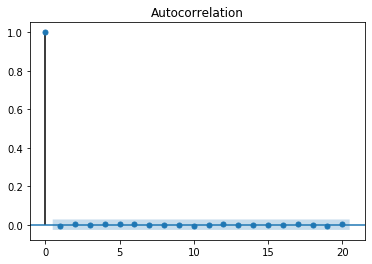

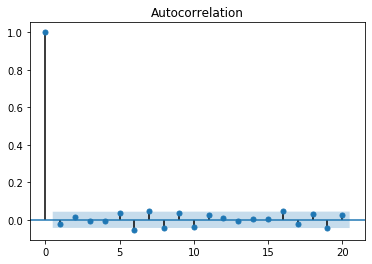

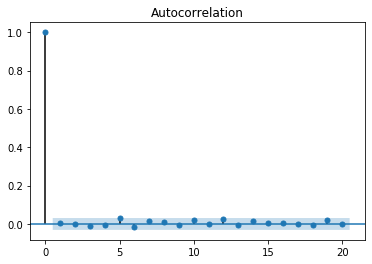

In [242]:
acf(apple_returns)
acf(fb_returns)
acf(google_returns)

 * There is no autocorrelation in these data

* **Are there any interesting relationships between the returns of different stocks at
the same time (contemporaneous) or different times?**

* First let's check correlation parameter

* We need to find the length of the shortest sequence to crop all datasets by this value

In [125]:
min(len(google_returns), len(fb_returns), len(apple_returns))

2066

In [129]:
data = {'FB': fb_returns[1:2066],
        'APPLE': apple_returns[1:2066],
        'GOOGLE': google_returns[1:2066]
        }

df = pd.DataFrame(data)

In [131]:
df.corr()

,FB,APPLE,GOOGLE
FB,1.000000,0.047626,0.335792
APPLE,0.047626,1.000000,0.036206
GOOGLE,0.335792,0.036206,1.000000


In [ ]:
## DONT FORGET Granger causality, PCA decomposition of returns

## QUESTION 3

* **Assume you have an equity strategy that every day makes a prediction f_i on the value of r_i**

* **The profit-and-loss (PNL) for each day is: pnl_i = f_i * r_i**

* **Assume that f_i is standard Gaussian with mean = 0 and std dev = 1**

* **Generate a few random realizations of f_i: plot pnl_i and pnl = cumsum(pnl_i)**

In [243]:
def pnl_proc(df):
    f_i = [np.random.normal(0, 1) for i in df.dropna()]
    pnl = df.dropna()*f_i
    plt.plot(pnl)
    plt.plot(pnl.cumsum())
    
    return f_i, pnl

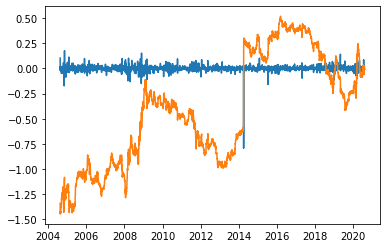

In [244]:
f_i_google, pnl_google = pnl_proc(google_returns)

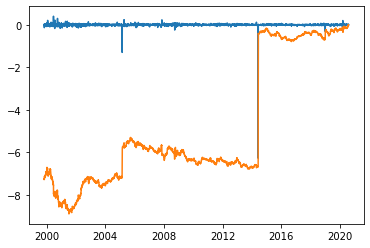

In [245]:
f_i_apple, pnl_apple = pnl_proc(apple_returns)

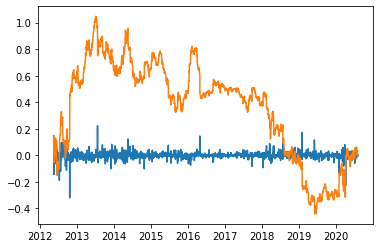

In [246]:
f_i_fb, pnl_fb = pnl_proc(fb_returns)

## QUESTION 4

* **For a PNL time series, define the Sharpe Ratio to be SR = E[pnl_i] / \sqrt{Var[pnl_i]}**
* **Assume that f_i has a given hit rate = 1/n \sum_i (sign(f_i) == sign(r_i))**


In [257]:
def sharp(pnl):
    return np.mean(pnl)/sqrt(np.var(pnl))

def hit(f_i, r_i):
    bools = [np.sign(fi)==np.sign(ri) for fi, ri in zip(f_i, r_i)]
    return 1/len(f_i)*sum(bools)
    

In [254]:
hit(f_i_google, google_returns)

0.5036096589494647

In [255]:
hit(f_i_apple, apple_returns)

0.5078513979318269

In [256]:
hit(f_i_fb, fb_returns)

0.49782082324455207

* **What is the distribution of the SR(pnl_i) given f_i?**

In [ ]:
# hmmmm...

## QUESTION 5

● **What if, instead of hit rate, you use root mean square error (RMSE) between f_i and r_i?**



In [285]:
def RMSE(f_i, r_i):
    mse = metrics.mean_squared_error(r_i.dropna(), f_i)
    return sqrt(mse)

In [ ]:
# you can find RMSE metrics in flexible_function demonstration below

● **How does the distribution of SR change?**


In [ ]:
# hmmmm...

● **What if you use mean absolute deviation (MAD) of f_i and r_i? Make the code flexible to changing input measures (hit rate, RMSE, MAD) and output
measures**


In [284]:
def MAD(f_i, r_i):
    r_i_mad = r_i.mad()
 
    f_i_mad = np.mean(np.absolute(f_i - np.mean(f_i))) 
    return r_i_mad, f_i_mad

In [268]:
MAD(f_i_apple, apple_returns)

(0.018836876896637534, 0.8007172922321771)

In [269]:
MAD(f_i_google, google_returns)

(0.01298544710531993, 0.8091736648764168)

In [270]:
MAD(f_i_fb, fb_returns)

(0.01523191874955076, 0.8056331752038071)

In [281]:
def flexible_function(f_i, r_i, method):
    method_map = {'hit': hit, 'RMSE':RMSE, 'MAD':MAD}
    return method_map[method](f_i, r_i)

In [286]:
flexible_function(f_i_fb, fb_returns, method='RMSE')

1.0047820021755922

In [288]:
flexible_function(f_i_apple, apple_returns, method='RMSE')

1.012770244064935

In [289]:
flexible_function(f_i_google, google_returns, method='RMSE')

1.0154944293504333